In [4]:
from models.dcgan import DCGAN
from models.discriminator import create_discriminator
from models.generator import create_generator, test_generator
from keras.optimizers import Adam
from utils.image_utils import read_collection
from utils.file_utils import make_directory
from utils.benchmark_utils import time_stamp, get_time
from utils.visualization_utils import save_plot
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
import config

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Reshape, Conv2DTranspose, Activation, BatchNormalization, UpSampling2D
from keras.layers import LeakyReLU
from keras.models import Sequential
import matplotlib.pyplot as plt

In [3]:
model = Sequential()

# Input Latent vector
model.add(Dense(4*4*100, input_dim=100))
# Reshape
model.add(Reshape((4, 4, 100)))

# Convolutional Layers
model.add(Conv2DTranspose(256, kernel_size=3, padding='same'))
model.add(UpSampling2D())

model.add(Conv2DTranspose(128, kernel_size=3, padding='same', strides=2))
model.add(UpSampling2D())

model.add(Conv2DTranspose(64, kernel_size=3, padding='same', strides=2))
model.add(LeakyReLU(alpha=0.2))

model.add(Conv2DTranspose(3, kernel_size=3, padding='same'))
model.add(Activation('tanh'))

2023-03-03 13:33:51.942097: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1600)              161600    
                                                                 
 reshape (Reshape)           (None, 4, 4, 100)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 4, 4, 256)        230656    
 nspose)                                                         
                                                                 
 up_sampling2d (UpSampling2D  (None, 8, 8, 256)        0         
 )                                                               
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 128)      295040    
 ranspose)                                                       
                                                        

1/1 [==============================] - 0s 137ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


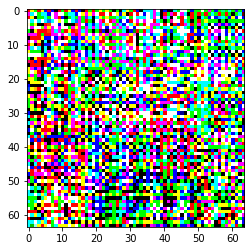

In [6]:
gen = create_generator(128)
noise = tf.random.normal([1, 128])
img = gen.predict(noise)
img = tf.reshape(img, shape=(img.shape[1], img.shape[2], img.shape[3]))
plt.imshow((img * 255))
plt.show()

In [ ]:
generator = create_generator(z=config.Z_DIM)
discriminator = create_discriminator(img_shape=config.IMG_SHAPE)

In [ ]:
generator.compile(loss='binary_crossentropy',
                 optimizer=Adam(learning_rate=0.0002, beta_1=0.4))

In [ ]:
discriminator.compile(loss='binary_crossentropy', 
                     optimizer=Adam(learning_rate=0.0002, beta_1=0.4),
                      metrics=['accuracy'])

In [ ]:
discriminator.trainable = False

In [ ]:
dcgan = DCGAN(generator, discriminator)
dcgan.compile(loss='binary_crossentropy',
             optimizer=Adam())

In [ ]:
dcgan = tf.keras.models.load_model("./model-py-test/dcgan/")

In [ ]:
discriminator_losses = []
gan_losses = []

In [ ]:
data_images = read_collection(config.DATA_TRAINING_PATH, 'jpg')

In [ ]:
plt.imshow(data_images[0])

In [ ]:
time_stamp("Generating labels ...", get_time())
real_labels = np.ones((config.BATCH_SIZE, 1))
fake_labels = np.zeros((config.BATCH_SIZE, 1))
time_stamp("Finishing ...", get_time())

In [ ]:
make_directory(config.MODEL_FOLDER_NAME)
make_directory(f'{config.MODEL_FOLDER_NAME}/predictions')

In [ ]:
ls

In [ ]:
for iteration in range(config.ITERATIONS):
    # Collect batch
    random_indicies = np.random.choice(
        len(data_images),
        size=config.BATCH_SIZE,
        replace=False)
    real_image_batch = np.array([data_images[i] for i in random_indicies]) / 127.5 - 1.0 # rescale [-1, 1]
    
    # Random batch of fake images
    z_fake = tf.random.normal([config.BATCH_SIZE, config.Z_DIM])
    generated_images = generator.predict(z_fake)
    
    discriminator.trainable = False
    # Train discriminator
    discriminator_real_loss = discriminator.train_on_batch(real_image_batch, real_labels)
    discriminator_fake_loss = discriminator.train_on_batch(generated_images, fake_labels)
    
    # Get discriminator loss and accuracy
    discriminator_loss, accuracy = 0.5 * np.add(discriminator_real_loss, discriminator_fake_loss)
    
    # Train generator
    z_fake = tf.random.normal([config.BATCH_SIZE, config.Z_DIM])
    generated_images = generator.predict(z_fake)
    
    # Get generator loss and accuracy
    gan_loss = dcgan.train_on_batch(z_fake, real_labels)
    
    # Append data
    discriminator_losses.append(discriminator_loss)
    gan_losses.append(gan_loss)
    
    # Progress output
    if (iteration + 1) % config.SAMPLE_INTERVAL == 0:
        print("Iteration %d, [D loss: %f, acc.:%.2f%%] [G loss: %f]" %( iteration+1, discriminator_loss, 100.0*accuracy, gan_loss))
        
        # Generate random images
        z_generated = tf.random.normal([3*3, 128])
        generate_images = generator.predict(z_generated)
        generate_images = 0.5 * generate_images + 0.5
        
        # Plot
        fig = plt.figure(figsize=(3, 3))
        fig, axs = plt.subplots(3, 3, sharex=True, sharey=True)
        
        cnt = 0
        for i in range(3):
            for j in range(3):
                # Get images from batch at index 'cnt'
                axs[i, j].imshow(generate_images[cnt])
                cnt += 1
        plt.savefig(f'{config.MODEL_FOLDER_NAME}/predictions/{iteration+1}.png')

In [ ]:
plt.clf()
save_plot(discriminator_losses, 'Discriminator Loss', config.MODEL_FOLDER_NAME, 'discriminator_loss')

In [ ]:
plt.clf()
save_plot(gan_losses, 'Gan Loss', config.MODEL_FOLDER_NAME, 'gan_loss')